<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_06/cats_dogs_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - classifying images from the Dogs vs. Cats Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_image-classification.ipynb

The Dogs vs. Cats dataset is a collection of images for binary image classification. It contains a training set of labeled images of cats and dogs, originally used in a Kaggle competition (2013). Each image is a color photo. The dataset provides a challenging problem of distinguishing between two visually similar categories and is widely used for experimenting with convolutional neural networks.

You can download the dataset from the following sources:
- https://www.kaggle.com/c/dogs-vs-cats
- https://www.microsoft.com/en-us/download/details.aspx?id=54765

We will work with a smaller dataset available at:
- http://zuzka.petricek.net/vyuka_2024/NES2_2024/data/cats_vs_dogs_small.zip

1. Download the zip file with the data
2. Extract the zip file

In [1]:
import requests
import zipfile
import os

zip_path = "cats_vs_dogs_small.zip"
url = "http://zuzka.petricek.net/vyuka_2024/NES2_2024/data/cats_vs_dogs_small.zip"
output_folder = "."

#base_folder ="cats_vs_dogs_small/"

# Download the zip file
response = requests.get(url)

# Save the zip file locally
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(output_folder)

# Clean up by removing the downloaded zip file
os.remove(zip_path)



## Process the data

### The required folder structure for image classification in Keras, TensorFlow and Pytorch
- The **root folder** should contain **three subdirectories**: `train`, `validation`, and `test`. The folders represent the essential division of the dataset into training, validation, and testing sets.
- Within each of these directories, images for separate classes are stored in **separate subfolders**. The name of each subfolder will be automatically used as the **class label**.

- This folder structure is required by Keras, TensorFlow, and PyTorch image loaders:
 - Keras functions such as `image_dataset_from_directory(directory)` or `flow_from_directory()`
  - PyTorch datasets such as `torchvision.datasets.ImageFolder`


### The format (structure) of the folder with data:
- in our case, the root folder contains three subdirectories: `train` (2000 images), `validation` (1000 images), and `test` (2000 images):

```
cats_vs_dogs_small/
├── train/
│   ├── Cat/
│   └── Dog/
├── validation/
│   ├── Cat/
│   └── Dog/
└── test/
│   ├── Cat/
│   └── Dog/
```

Observe the number of images in each folder:
- the dataset is balanced

In [2]:
import os

base_dir = "cats_vs_dogs_small"

for split in ["train", "validation", "test"]:
    split_dir = os.path.join(base_dir, split)
    print(f"\n{split.upper()}:")
    for category in ["Cat", "Dog"]:
        category_dir = os.path.join(split_dir, category)
        num_images = len(os.listdir(category_dir))
        print(f"  {category}: {num_images} images")


TRAIN:
  Cat: 1000 images
  Dog: 1000 images

VALIDATION:
  Cat: 500 images
  Dog: 500 images

TEST:
  Cat: 1000 images
  Dog: 1000 images


Observe some images:

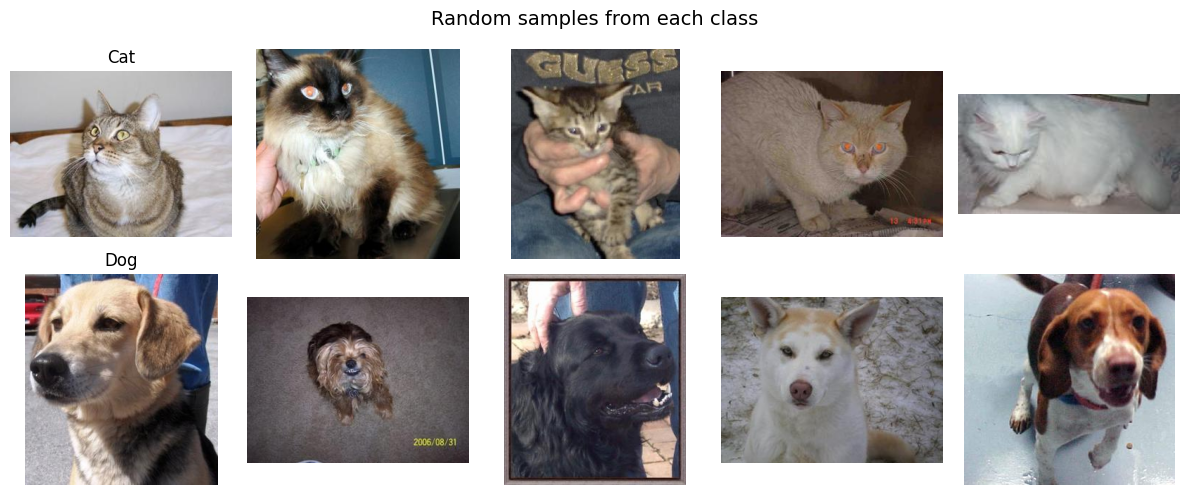

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_dir = "cats_vs_dogs_small/train"
classes = ["Cat", "Dog"]

fig, axes = plt.subplots(len(classes), 5, figsize=(12, 5))
fig.suptitle("Random samples from each class", fontsize=14)

for i, cls in enumerate(classes):
    class_dir = os.path.join(base_dir, cls)
    images = random.sample(os.listdir(class_dir), 5)

    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(cls)

plt.tight_layout()
plt.show()

### Create Datasets from folders
- **`image_dataset_from_directory(directory)`**:
 - available in Keras with TensorFlow backend only – not compatible with PyTorch)
  1. Assumes the folder structure follows the format: class-specific subfolders within `train`, `validation`, and `test` directories.
  2. Scans and indexes image files in each subdirectory, automatically assigning labels based on folder names.
  3. Returns a `tf.data.Dataset` object that:
     - Loads and shuffles the files,
     - Decodes images into tensors,
     - Resizes images to a consistent size,
     - Batches images for efficient model training and evaluation.


https://keras.io/api/data_loading/image/

In [4]:
image_size = (180, 180)
batch_size = 32

base_folder ="cats_vs_dogs_small/"

from keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    base_folder + "train",
    image_size=image_size,
    seed=42,
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    base_folder  + "validation",
    image_size=image_size,
    seed=42,
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    base_folder  + "test",
    image_size=image_size,
    shuffle = False,
    seed=42,
    batch_size=batch_size)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


- `tf.data.Dataset` is an iterator:

In [5]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break
for data_batch, labels_batch in validation_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### More about tf.data.Dataset:

In [6]:
# Another example of a dataset:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

# iteration over examples:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

# iteration over batches:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

# iteration over batches with map:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


## Define and train the model

### Simple CNN model for binary classification:
- Start with a keras.Input layer specifying the input shape, e.g., 180x180x3.
- Add Rescaling Layer to normalize the pixels
- Add multiple blocks of Conv2D (with 'relu' activation) followed by MaxPooling2D to progressively extract spatial features.
- Then add a Flatten layer to convert 2D feature maps to 1D vector.
- Optionally, include one or more Dense layers with 'relu' (or 'tanh') activations for further feature extraction.
- Use 'sigmoid' activation function in the output layer for binary classification.




In [7]:
import keras
from keras import layers

# Define the model architecture:
def get_model():

    # ---------------
    # base:
    inputs = keras.Input(shape=image_size + (3, ))
    x = layers.Rescaling(1./255)(inputs) # Normalize pixels

    # Convolutional blocks
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    #x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    x = layers.Flatten()(x)

    # ---------------
    # head:
    x = layers.Dense(32, activation='relu')(x)
    #x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
model = get_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,638,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,713 (6.61 MB)

 Trainable params: 1,731,713 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Test Accuracy", "Test Loss", "Train Accuracy", "Train Loss", "Time (s)", "Epochs", "Details"]
results_df = pd.DataFrame(columns=columns)

In [9]:
# plot the training progress:
def plot_history(history):
    history_dict = history.history
    print(history_dict.keys())

    from matplotlib import pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     1,638,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,713 (6.61 MB)

 Trainable params: 1,731,713 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.5118 - loss: 0.8700 - val_accuracy: 0.5270 - val_loss: 0.6894
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5462 - loss: 0.6854 - val_accuracy: 0.5460 - val_loss: 0.6964
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6239 - loss: 0.6608 - val_accuracy: 0.5940 - val_loss: 0.7055
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6499 - loss: 0.6042 - val_accuracy: 0.6850 - val_loss: 0.6038
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7481 - loss: 0.5343 - val_accuracy: 0.7010 - val_loss: 0.6118
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7879 - loss: 0.4613 - val_accuracy: 0.6700 - val_loss: 0.6941
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8267 - loss: 0.3947 - val_accuracy: 0.6990 - val_loss: 0.7269
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.8624 - loss: 0.3124 - val_accuracy: 0.6980 - v

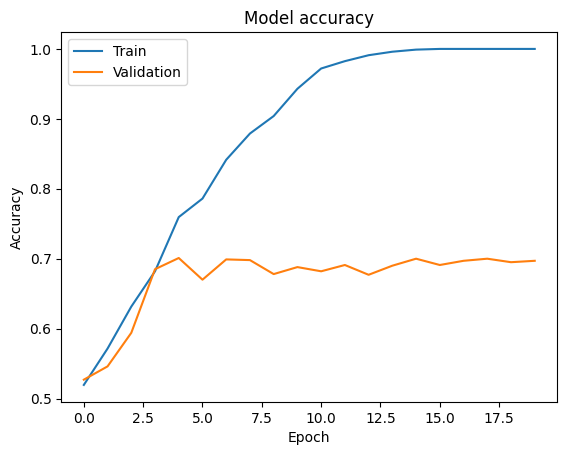

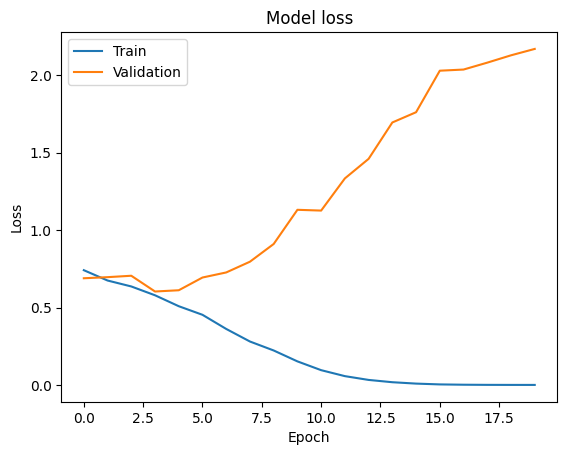

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step - accuracy: 1.0000 - loss: 3.0672e-04
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 575ms/step - accuracy: 0.6938 - loss: 2.1038
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step - accuracy: 0.7322 - loss: 2.0002
Training accuracy: 1.0 
Train loss: 0.0002900239487644285
Validation accuracy: 0.6970000267028809 
Val loss: 2.1706933975219727
Test accuracy: 0.7014999985694885 
Test loss: 2.137979507446289
Results:
                        Model Name              Details  Test Accuracy  \
0  cnn_catsdogs_from_scratch.keras  False-ep.:20-bs:32          0.7015   

   Test Loss  Train Accuracy  Train Loss     Time (s)  Epochs  
0    2.13798             1.0     0.00029  3236.614732      20  


In [10]:
# Set some of the hyperparameters:
do_early_stopping = False
do_tensorboard = True
max_epochs = 20

details = "" # your comment

###############################################
# Define the model architecture:
import keras
from keras import layers
# Define the model architecture
model = get_model()

import datetime
model_name = 'cnn_catsdogs_from_scratch.keras'
model.summary()

# Configure the model:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)  # Adam, RMSProp, SGD
model.compile(optimizer=optimizer,
                  loss= keras.losses.BinaryCrossentropy(),
                  metrics= [keras.metrics.BinaryAccuracy("accuracy")])

###############################################
# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
else:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss", restore_best_weights=True)
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_flowers/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset, epochs=max_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

# Evaluate the model on the training, validation and test sets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
model_details = f"{do_early_stopping}-ep.:{max_epochs}-bs:{batch_size} {details}"
new_entry = {
    "Model Name" : model_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : train_loss,
    "Time (s)" : time_fit,
    "Epochs" : len(history.epoch),
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# View and and save the dataframe:
results_df.to_csv(model_dir + "mnist_results.csv", index=False)
print("Results:")
print(results_df)


## Confusion matrix and some misclassified images

Predicted labels: [np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(1.0), np.float32(0.0), np.float32(1.0)]
True labels: [np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]
Number of misclassified images: 597 out of 2000 , accuracy: 0.7015


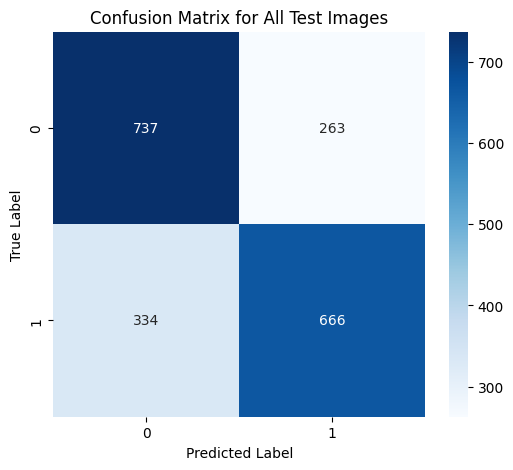

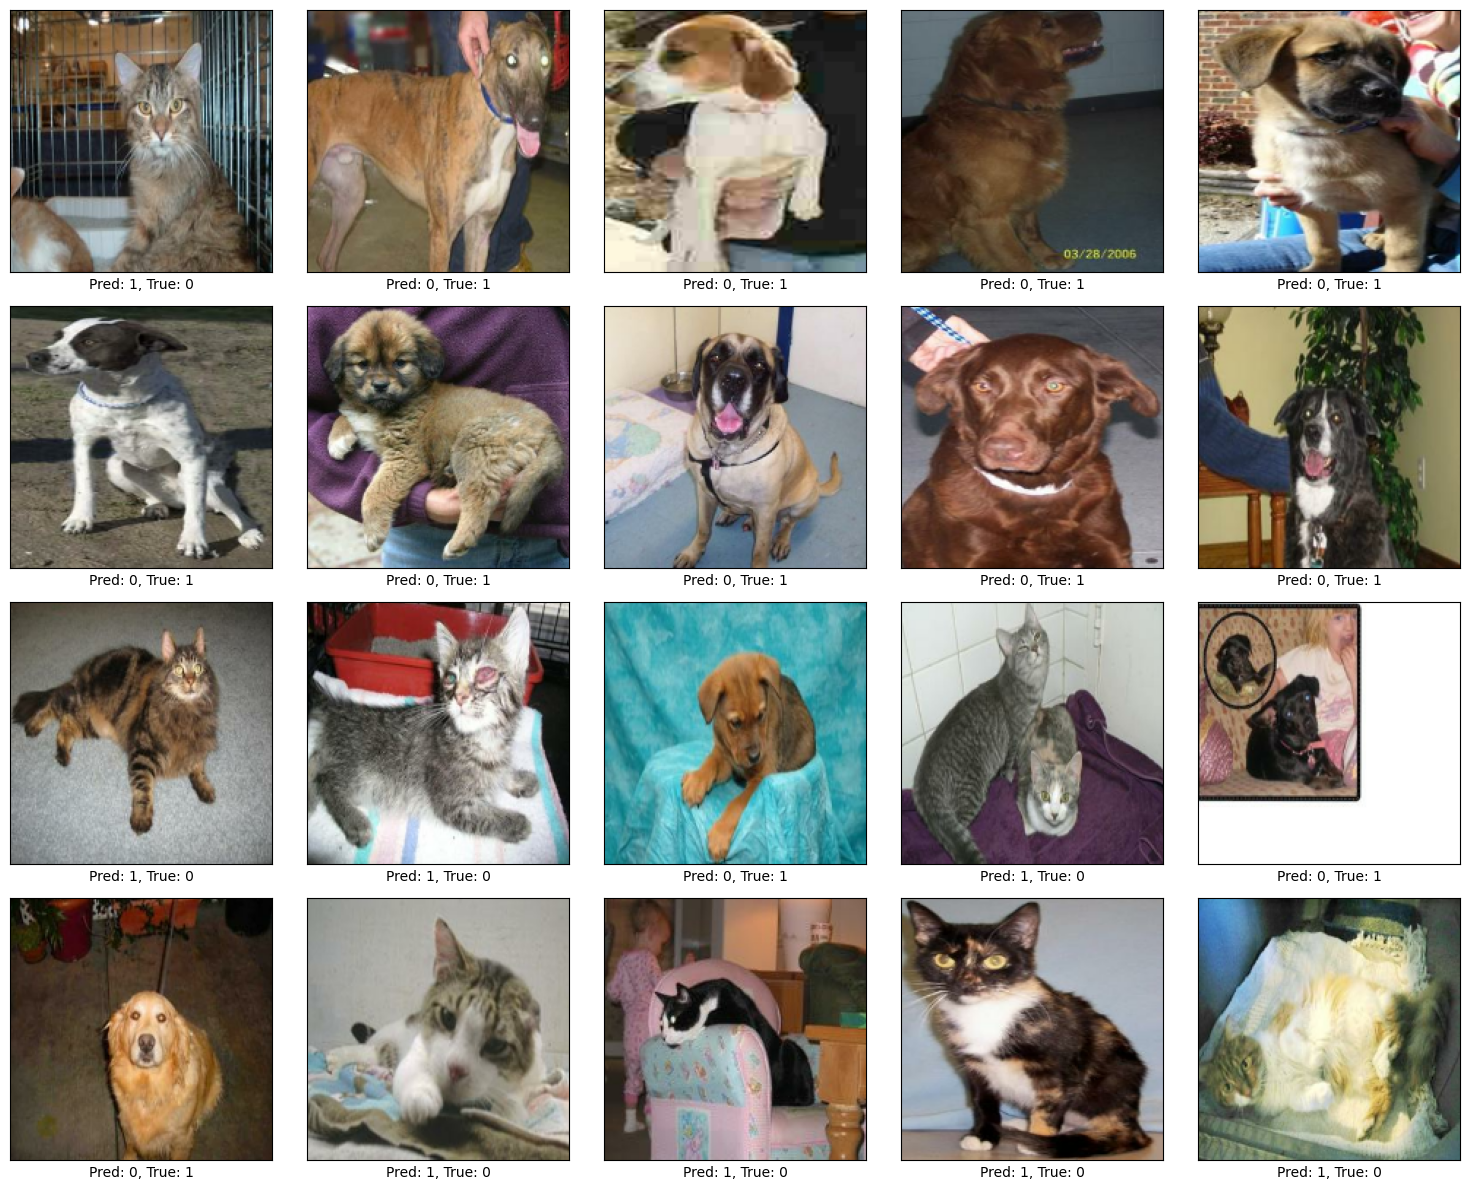

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []


for images, labels in test_dataset:
    preds = model.predict(images, verbose=False)
    preds = tf.round(preds).numpy().flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


    for i in range(len(images)):
        if preds[i] != labels[i].numpy():  # Chybně klasifikováno
            misclassified_images.append(images[i].numpy())
            misclassified_labels.append(labels[i].numpy())
            misclassified_predictions.append(int(preds[i]))

print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
misclassified_images = np.array(misclassified_images)
misclassified_labels = np.array(misclassified_labels)
misclassified_predictions = np.array(misclassified_predictions)

# Calculate the number of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
test_acc = (len(y_true) - num_misclassified) / len(y_true)
print("Number of misclassified images:", num_misclassified,
      "out of", len(y_true), ", accuracy:", test_acc)

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Test Images')
plt.show()

# plot some misclassified images
num_images_to_plot = 20
random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 4 řádky, 5 sloupců
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified_images[index].astype("uint8"))
    plt.xlabel(f"Pred: {misclassified_predictions[index]}, True: {misclassified_labels[index]}")
plt.tight_layout()
plt.show()


## Visualizations

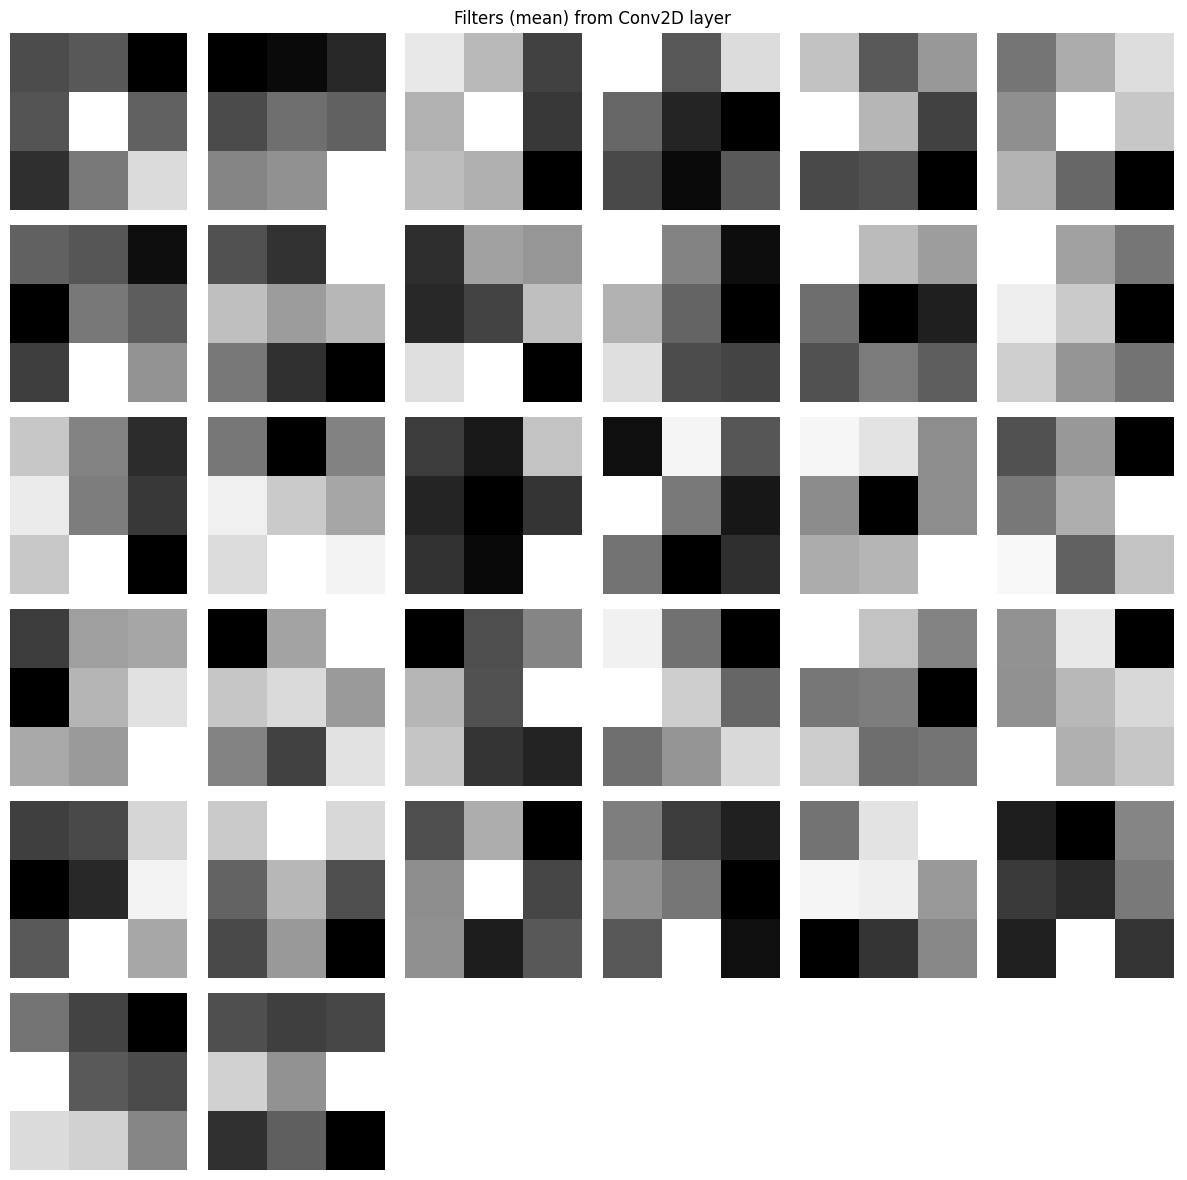

In [12]:
def visualize_filters(conv_layer, mode="first"):
    """
    Visualize learned filters (weights) of a Conv2D layer.

    Parameters:
    - conv_layer: Keras Conv2D layer
    - mode: "first" (only first input channel),
            "all" (all channels per filter in separate figures),
            "mean" (average over input channels per filter)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    weights, biases = conv_layer.get_weights()
    kernel_height, kernel_width, input_channels, output_channels = weights.shape

    def get_grid_dims(n):
        cols = math.ceil(math.sqrt(n))
        rows = math.ceil(n / cols)
        return rows, cols

    if mode in ["first", "mean"]:
        rows, cols = get_grid_dims(output_channels)
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axs = axs.flatten()

        for i in range(output_channels):
            if mode == "first":
                f = weights[:, :, 0, i]
            else:  # mean
                f = np.mean(weights[:, :, :, i], axis=-1)
            axs[i].imshow(f, cmap='gray')
            axs[i].axis('off')

        for j in range(output_channels, len(axs)):
            axs[j].axis('off')

        plt.suptitle(f"Filters ({mode}) from Conv2D layer")
        plt.tight_layout()
        plt.show()

    elif mode == "all":
        for i in range(output_channels):
            fig, axs = plt.subplots(1, input_channels, figsize=(input_channels * 2, 2))
            for j in range(input_channels):
                ax = axs[j] if input_channels > 1 else axs
                f = weights[:, :, j, i]
                ax.imshow(f, cmap='gray')
                ax.set_title(f"In ch. {j}")
                ax.axis('off')
            plt.suptitle(f"Filter {i} (all input channels)")
            plt.tight_layout()
            plt.show()
    else:
        raise ValueError("Unknown mode: choose 'first', 'mean', or 'all'")


# Visualize filters as average of all input channels
visualize_filters(model.layers[2], mode="mean")  # change the layer index: 2, 4, 6

# Visualize filters from the second Conv2D layer (show all input channels)
#visualize_filters(model.layers[2], mode="all")

### Feature maps

In [13]:
image_index = 2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get one image from the training set
for image_batch, label_batch in train_dataset.take(1):
    sample_image = image_batch[image_index].numpy()
    break

# Create an intermediate model that outputs activations from all Conv2D layers
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Run the image through the intermediate model
sample_input = np.expand_dims(sample_image, axis=0)  # Add batch dimension
feature_maps = activation_model.predict(sample_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


- for any conv. layer:

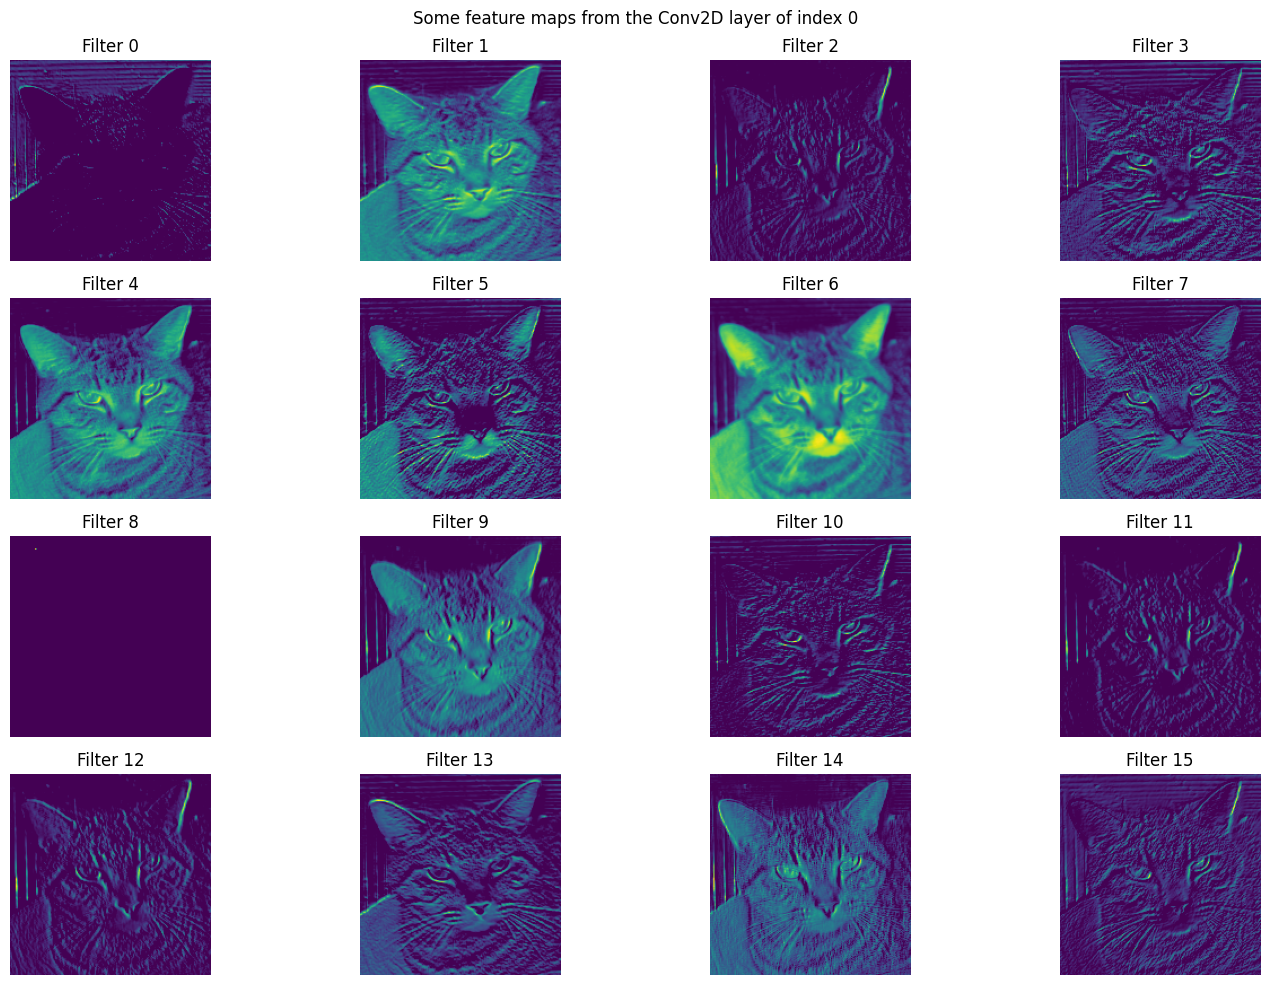

In [14]:
layer_index = 0 # 0, 1, 2

# Visualize feature maps from the first Conv2D layer
first_layer_maps = feature_maps[layer_index]  # First layer's activation output

num_filters = first_layer_maps.shape[-1]
size = first_layer_maps.shape[1]

plt.figure(figsize=(15, 10))
for i in range(min(num_filters, 16)):  # Show up to 16 filters
    plt.subplot(4, 4, i + 1)
    plt.imshow(first_layer_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i}')
plt.suptitle(f'Some feature maps from the Conv2D layer of index {layer_index}')
plt.tight_layout()
plt.show()

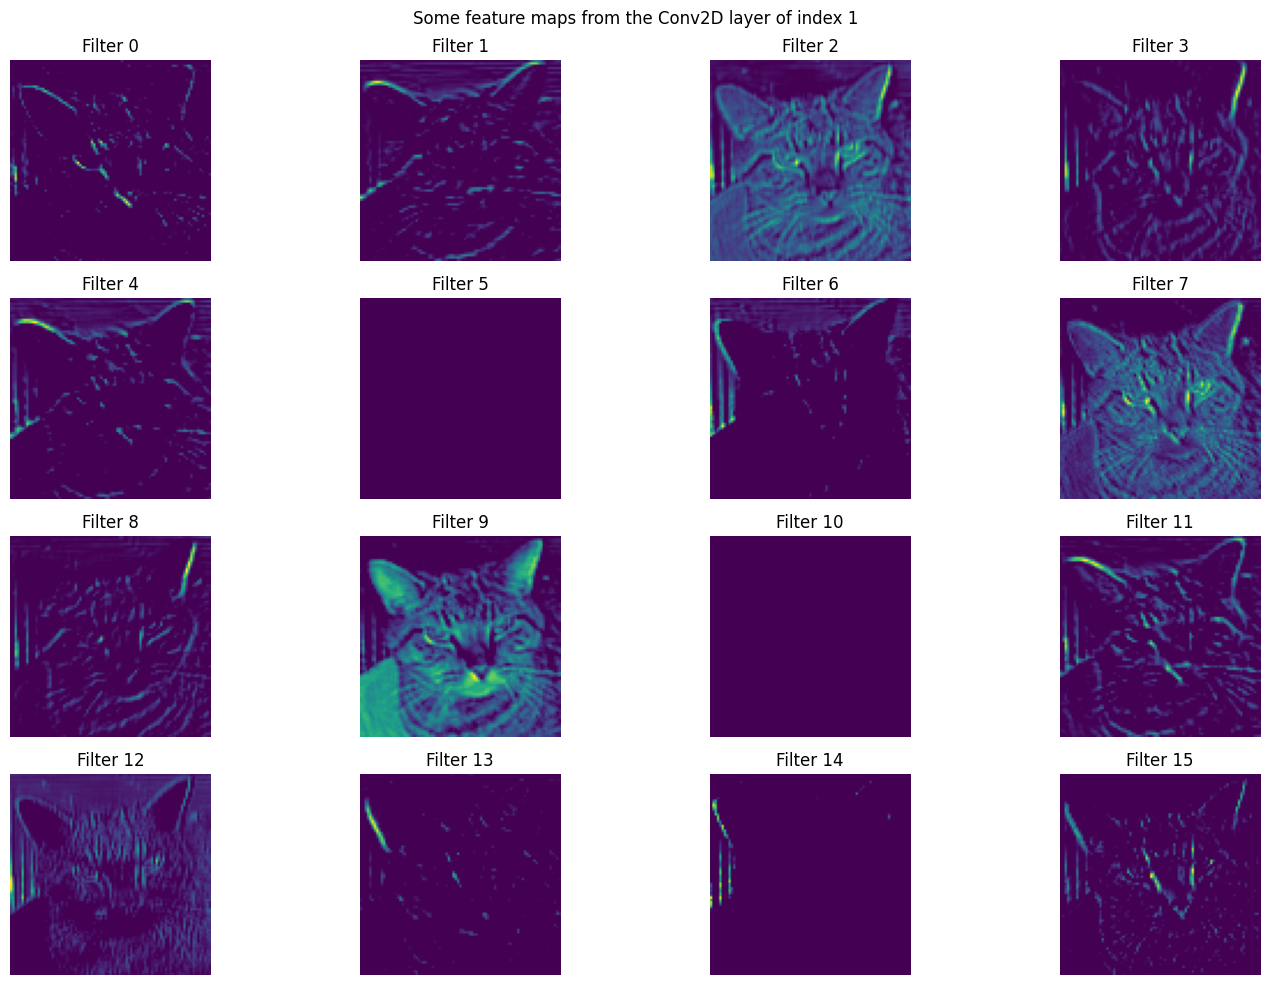

In [15]:
layer_index = 1 # 0, 1, 2

# Visualize feature maps from the first Conv2D layer
first_layer_maps = feature_maps[layer_index]  # First layer's activation output

num_filters = first_layer_maps.shape[-1]
size = first_layer_maps.shape[1]

plt.figure(figsize=(15, 10))
for i in range(min(num_filters, 16)):  # Show up to 16 filters
    plt.subplot(4, 4, i + 1)
    plt.imshow(first_layer_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i}')
plt.suptitle(f'Some feature maps from the Conv2D layer of index {layer_index}')
plt.tight_layout()
plt.show()

### Saliency map

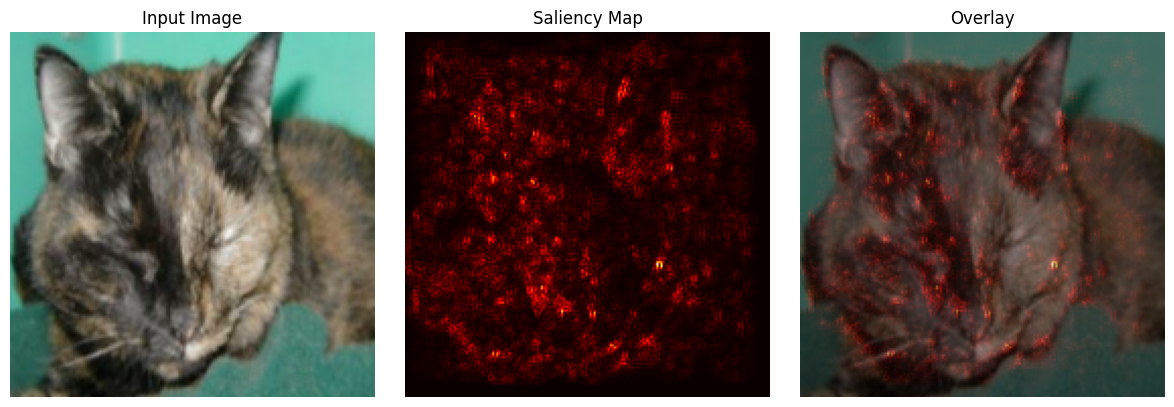

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def visualize_saliency_map(model, image, label=None):
    """
    Generate a saliency map for an input RGB image,
    showing which pixels most affect the model's decision.
    """
    image_tensor = tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)

    # Get prediction and inferred label if not provided
    predictions = model.predict(image_tensor, verbose=0)
    if label is None:
        label = tf.argmax(predictions[0])

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        preds = model(image_tensor)
        loss = preds[:, label]

    # Compute gradient of the output w.r.t. input image
    gradient = tape.gradient(loss, image_tensor)[0]

    # Saliency map: absolute max gradient across channels
    saliency = tf.reduce_max(tf.abs(gradient), axis=-1)

    # Normalize saliency to [0, 1]
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
    saliency = saliency.numpy()

    # Convert image to displayable format if needed
    if image.max() <= 1.0:
        image_display = (image * 255).astype("uint8")
    else:
        image_display = image.astype("uint8")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image_display)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Saliency Map")
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image_display)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


image_index = 20
# Get one image from the dataset
for images, labels in train_dataset.take(1):
    image = images[image_index].numpy()
    label = labels[image_index].numpy()
    break

# Call the saliency map function
visualize_saliency_map(model, image, label)

# Exercise
- finetune the architecture and hyperparameters and observe the results
- observe the features extracted from the data
- what is the accuracy of the final model?

# Training with data augmentation and regularization

## Data augmentation
- Define a data augmentation layer:

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ]
)

- display some randomly augmented training images

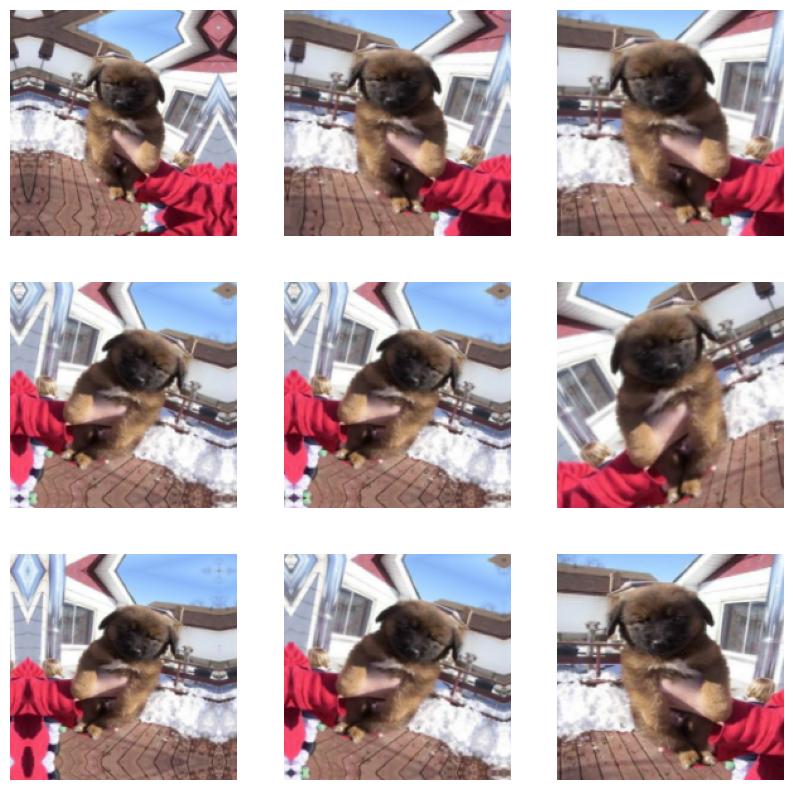

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Data augmentation + dropout:
- define the regularized model:

In [ ]:
data_augmentation = keras.Sequential(
    [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomTranslation(0.1, 0.1),
    ]
)

def get_regularized_model():
      import keras
      from keras import layers
      # Base
      # Input layer
      inputs = keras.Input(shape=image_size + (3, ))

      # Augment the data
      x = data_augmentation(inputs)             # NEW

      # Normalize pixels
      x = layers.Rescaling(1./255)(x)

      # Convolutional blocks
      x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)

      x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)

      x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
      x = layers.MaxPooling2D(pool_size=2)(x)

      #x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

      x = layers.Flatten()(x)

      # Head
      x = layers.Dense(32, activation='relu')(x)
      x = layers.Dropout(0.3)(x)                # NEW

      # Output layer for binary classification
      outputs = layers.Dense(1, activation="softmax")(x)

      # Build model
      model = keras.Model(inputs=inputs, outputs=outputs)
      return model

model = get_regularized_model()
model.summary()


In [ ]:
# Set some of the hyperparameters:
do_early_stopping = False
do_tensorboard = True
# max_epochs = 20

details = "" # your comment

###############################################
# Define the model architecture:
import keras
from keras import layers
# Define the model architecture
model = get_regularized_model()

import datetime
model_name = 'cnn_catsdogs_augmented.keras'
model.summary()

# Configure the model:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)  # Adam, RMSProp, SGD
model.compile(optimizer=optimizer,
                  loss= keras.losses.BinaryCrossentropy(),
                  metrics= [keras.metrics.BinaryAccuracy("accuracy")])

###############################################
# Define callbacks (e.g., early stopping):
callbacks = []
if do_early_stopping:
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    callbacks.append(early_stopping)
else:
    from keras.callbacks import ModelCheckpoint
    checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss", restore_best_weights=True)
    callbacks.append(checkpoint)
if do_tensorboard:
    from keras.callbacks import TensorBoard
    tensorboard_callback = TensorBoard(log_dir="./logs_flowers/"+model_name, histogram_freq=1, write_steps_per_second=True)
    callbacks.append(tensorboard_callback)

################################################
# Train the model
import time
start_time = time.time()
history = model.fit(train_dataset, epochs=max_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
time_fit = time.time() - start_time

###############################
# Plot the training progress:
plot_history(history)

# Evaluate the model on the training, validation and test sets
train_loss, train_acc = model.evaluate(train_dataset)
val_loss, val_acc = model.evaluate(validation_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

###############################
# Save the model:
import os
model_dir = "./models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model.save(model_dir + model_name)

#################################
# Add results to the dataframe:
model_details = f"{do_early_stopping}-ep.:{max_epochs}-bs:{batch_size} {details}"
new_entry = {
    "Model Name" : model_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : train_loss,
    "Time (s)" : time_fit,
    "Epochs" : len(history.epoch),
}
if 'results_df' not in locals() or results_df is None or results_df.empty:
    results_df = pd.DataFrame([new_entry])
else:
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
# View and and save the dataframe:
results_df.to_csv(model_dir + "mnist_results.csv", index=False)
print("Results:")
print(results_df)


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []


for images, labels in test_dataset:
    preds = model.predict(images, verbose=False)
    preds = tf.round(preds).numpy().flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


    for i in range(len(images)):
        if preds[i] != labels[i].numpy():  # Chybně klasifikováno
            misclassified_images.append(images[i].numpy())
            misclassified_labels.append(labels[i].numpy())
            misclassified_predictions.append(int(preds[i]))

print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
misclassified_images = np.array(misclassified_images)
misclassified_labels = np.array(misclassified_labels)
misclassified_predictions = np.array(misclassified_predictions)

# Calculate the number of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
test_acc = (len(y_true) - num_misclassified) / len(y_true)
print("Number of misclassified images:", num_misclassified,
      "out of", len(y_true), ", accuracy:", test_acc)

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Test Images')
plt.show()

# plot some misclassified images
num_images_to_plot = 20
random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 4 řádky, 5 sloupců
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified_images[index].astype("uint8"))
    plt.xlabel(f"Pred: {misclassified_predictions[index]}, True: {misclassified_labels[index]}")
plt.tight_layout()
plt.show()


## Bath normalization

In [ ]:
###############################################
# Define the log directory for TensorBoard
import os
import datetime
import keras
import tensorflow as tf

model_datetime_name = "cats_dogs_cnn_augment_batch"+  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit_cd/" + model_datetime_name
# print(os.getcwd())

# Clear any logs from previous runs
# !rm -rf ./logs/

# Ensure the directory exists
if not os.path.exists(os.path.dirname(log_dir)):
    os.makedirs(os.path.dirname(log_dir))

###############################################
# Initialize Tensorboard callback
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # Visualize histograms of layer weights
    write_graph=True,  # Log the graph to visualize the model structure
    write_images=True  # Optionally, save images of weights and activation histograms
    # update_freq='batch'  # Log metrics after every batch
    # write_steps_per_second=True  # Log steps per second during training
)
################################################


import keras
from keras import layers
# Define the model architecture
inputs = keras.Input(shape=image_size + (3, ))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = keras.layers.Conv2D(32, kernel_size=3, use_bias = False)(x)
x = keras.layers.BatchNormalization()(x)  # Add batch normalization
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)

x = keras.layers.Conv2D(64, kernel_size=3, use_bias = False)(x)
x = keras.layers.BatchNormalization()(x)  # Add batch normalization
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)

x = keras.layers.Conv2D(128, kernel_size=3, use_bias = False)(x)
x = keras.layers.BatchNormalization()(x)  # Add batch normalization
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)

x = keras.layers.Conv2D(256, kernel_size=3, use_bias = False)(x)
x = keras.layers.BatchNormalization()(x)  # Add batch normalization
x = keras.layers.Activation('relu')(x)


x = layers.Flatten()(x)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.1)(x)                # NEW
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.BinaryCrossentropy(),
              metrics= [keras.metrics.BinaryAccuracy("accuracy")])

num_epochs = 100

checkpoint =     keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch_with_augmentation_bn.keras",
        save_best_only=True,
        monitor="val_loss")


early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=[tensorboard_callback, checkpoint])
    #callbacks=[tensorboard_callback, early_stopping])

model = keras.models.load_model("models/convnet_from_scratch_with_augmentation_bn.keras")

# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_dataset)
print('Training accuracy:', train_acc, '\nTrain loss:', train_loss)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy:', val_acc, '\nVal loss:', val_loss)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc, '\nTest loss:', test_loss)

model_details = "augmented + batch"
# Add results to the dataframe:
new_entry = {
    "Model Name" : model_datetime_name,
    "Details" : model_details,
    "Test Accuracy" : test_acc,
    "Test Loss" : test_loss,
    "Train Accuracy" : train_acc,
    "Train Loss" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv(model_dir + "mnist_cnn_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []


for images, labels in test_dataset:
    preds = model.predict(images, verbose=False)
    preds = tf.round(preds).numpy().flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)


    for i in range(len(images)):
        if preds[i] != labels[i].numpy():  # Chybně klasifikováno
            misclassified_images.append(images[i].numpy())
            misclassified_labels.append(labels[i].numpy())
            misclassified_predictions.append(int(preds[i]))

print("Predicted labels:", y_pred[:10])
print("True labels:", y_true[:10])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
misclassified_images = np.array(misclassified_images)
misclassified_labels = np.array(misclassified_labels)
misclassified_predictions = np.array(misclassified_predictions)

# Calculate the number of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
num_misclassified = len(misclassified_indices)
test_acc = (len(y_true) - num_misclassified) / len(y_true)
print("Number of misclassified images:", num_misclassified,
      "out of", len(y_true), ", accuracy:", test_acc)

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for All Test Images')
plt.show()

# plot some misclassified images
num_images_to_plot = 20
random_indices = random.sample(range(len(misclassified_images)), min(num_images_to_plot, len(misclassified_images)))

plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)  # 4 řádky, 5 sloupců
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified_images[index].astype("uint8"))
    plt.xlabel(f"Pred: {misclassified_predictions[index]}, True: {misclassified_labels[index]}")
plt.tight_layout()
plt.show()


In [ ]:
###############################################
# Load TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training begins
%tensorboard --logdir logs/fit_cd --reload_interval=1